# Week of 2025.08.11 

## TODO
- [x] Add mach number to 1D atmosphere. 
- [x] Also simulate the 1D eruption with 0.1m accuracy to see if the low sound speed by the outlet goes away.
- [x] Talk to Mario about the new method for calculating the lighthill stress tensor. 
- [x]  Apply light hill's theorm to Fred's code. 
- [x] Higher fidelity to 2D simulation. 
- [ ] Implememt Mario's new method for lighthill analysis
- [ ] Update method to work in 3D 
- [ ] Review math and end result that allows us to solve for pressure as a function of finite differences. 
- [ ] Seems to be a bug where all the top of the sphere is define as zero -- maybe some nan is being introduced somehow? That is the downside to the way I am handling nans. 



## Sherlock notes 
- On 08/11 I started a sherlock simulation that did not crash but did not start either:
    in theory it was running:
    ```
    [paxtonsc@sh02-ln02 login /oak/stanford/groups/edunham/paxtonsc]$ squeue --me
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3533174      serc run_quai paxtonsc  R    1:54:25      1 sh04-06n26

    ```
- Well lets try the dumb thing `scancel <job-id>` and then run the thing again. 


## Questions for Eric 
1. Analytical/numerical time/spatial derivative of Green's function. 
2. My method for solving in 2D? I think I am probably introducing error because in practice there are dipole and monolpole source terms at all angles. 
3. validation/verification methods for my surface integral that matches Mario's derivations. 
    

In [1]:
%load_ext autoreload
%autoreload 2

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit, get_quantities_at_all_space
from helper_code.animate import animate_conduit_pressure, animate_melt_atmosphere_combination
from helper_code.analytical_solution import get_lumped_solution

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 10
C0 = 320 # m/s at 5000m

## 1.0 Review 1D eruption with mach number

In [2]:
folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
melt_file_name = "tungurahua_atm_01m"
atmosphere_file_name = "vertical_atmosphere_02_atm1"
melt_solver_func = get_local_solver_from_index_func(folder_name, melt_file_name)
atmosphere_solver_func = get_local_solver_from_index_func(folder_name, atmosphere_file_name)

iters = 100

ani = animate_melt_atmosphere_combination(
    melt_solver_func,
    atmosphere_solver_func,
    iterations=100,
    d_iterations=8,
    y_min=-1000,
    y_max=1000,
    max_pressure=0.13,
    min_pressure=0.07,
    max_velocity=50,
    min_velocity=0,
    max_density=3e3,
    min_density=0,
    max_slip=150,
    min_slip=0,
    max_speed_of_sound=100
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/1d_atmosphere_combination.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())

## 2.0 Implement Mario's surface integral approach to Lighthill's stress tensor

Mario shared [his notes](https://drive.google.com/file/d/1jzvBcMYeOEyDCObKhD19dqmRt0bwFYaI/view?usp=sharing) with me where he derives a surface integral to calculate pressure at an observer location. 


Mario starts with the Lighthill equation we are familiar with:

$$
p'(x,t) = \frac{\partial^2}{\partial x_i \partial x_j} \int_v T_{ij}(\bar{x}', t) * G(\bar{x}, t, \bar{x}') dV (\bar{x}')
$$

where 
- $\bar{x}$ is the receiver location
- $\bar{x}'$ is the source location

The volume integral is done over $\bar{x}'$. 

Assuming we trust Mario's derivation, his end result is: 

$$
p'(x, t) = - \int_S n_i (\rho v_i v_j + p_{ij}) * \frac{\partial G}{\partial x_i} dS(\bar{x}') + \int_S n_i (\rho v_i) * \frac{\partial G}{\partial t} dS (\bar{x}')
$$

Some helpful points:
1. $v$ is the velocity vector at a given point. This is an output from Fred's code. 
2. $p$ is a stress tensor at a given point. How do I calculate this? It looks like because our flow is inviscid it is possible to calculate the stress tensor as $\sigma_{ij} = - p \delta_{ij}$

For the moment, let's consider the 2D Green's function 

$$
G(\bar{x}, \bar{x}', t) = \frac{\delta(t - \frac{|\bar{x} - \bar{x}'|}{c_0})}{4 \pi (\bar{x} - \bar{x}')}
$$




## 3.0 Use Fred's data from his eruption to test Mario's approach

In [178]:
# First, navigate to the sherlock mount point 

import os

os.chdir("/Users/paxton/git/volcano_sims/fred_data")

print(os.getcwd())
print(os.listdir())

# Load compressed npz archive
# The archive contains the field "time" and "state_coeffs"
#   archive["time"] is an np.array with size (n_timesteps)
#   archive["state_coeffs"] is an np.array with size (n_timesteps, n_elems, n_basis, n_states)
# The field "state_coeffs" contains the solver.state_coeffs variables for all
# the output files, combined into one array.

# Example below (loading multiple at a time may use a lot of memory):
archive = np.load(f"refblastH4_atm1.npz")

/Users/paxton/git/volcano_sims/fred_data
['refblastH4_atm2_0.pkl', 'refblastH4_atm1.npz', 'test_data.npz', 'refblastH4_atm2.npz', 'refblastH4_atm3.npz', 'refblastH4_atm1_0.pkl', 'refblastH4_atm3_0.pkl']


In [704]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("fred_data", f"refblastH4_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 300, 200)
base_y = np.linspace(-125, 300, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,archive["time"].shape[0]//4,4)

print(file_index_list.size)

225


In [705]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		state_coeffs = archive["state_coeffs"][file_idx, ...]

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			#U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

            # I believe this is the correct calculation for order 1
			U_union[time_idx,write_idx,:] = (state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]) + state_coeffs[ie,1,:] * ref_coords_loc[0] + state_coeffs[ie,2,:] * ref_coords_loc[1])

In [708]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))

t_range = np.linspace(0, archive["time"].max(), archive["time"].shape[0])

In [709]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

### Calculate velocity vector

Both the x and y components of velocity are in the state variable. 

In [710]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation - u is velocity in x-direction
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

# v is velocity in y-direction
v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

In [1045]:
v_data = np.stack((mg_u, mg_v), axis=-1)


### Calculate Stress tensor 

The fluid is inviscid, so the stress simplifies to 

$$\sigma_{ij} = - \rho \delta_{ij}$$

In [756]:
mg_sigma = np.zeros((*mg_p.shape, 3, 3))

mg_sigma[:,:,:,0,0] = -mg_p
mg_sigma[:,:,:,1,1] = -mg_p
mg_sigma[:,:,:,2,2] = -mg_p


Text(0.5, 1.0, 'Density at t=2.00 s')

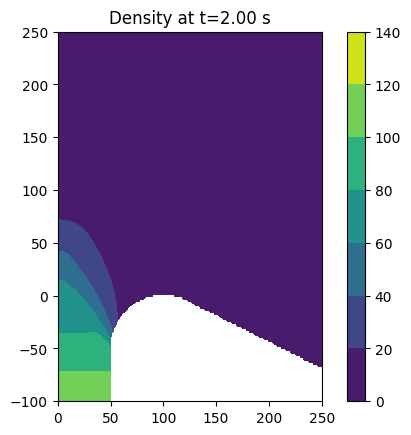

In [714]:
t_ind=30
plt.contourf(mg_x, mg_y, mg_rho[t_ind,:,:])
plt.xlim(0, 250)
plt.ylim(-100, 250)
plt.gca().set_aspect('equal')  # Set equal aspect ratio
plt.colorbar()
plt.title(f"Density at t={t_range[file_index_list[t_ind]]:.2f} s")

Text(0.5, 1.0, 'Velocity (z) at t=2.00 s')

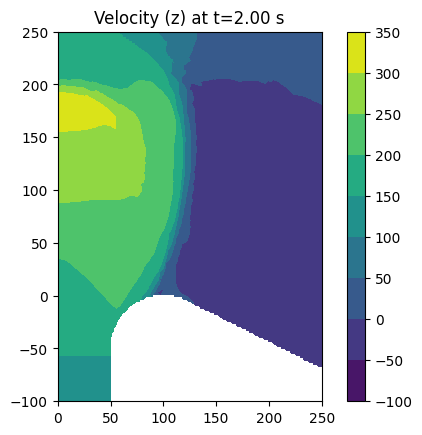

In [715]:
t_ind=30
plt.contourf(mg_x, mg_y, mg_v[t_ind,:,:])
plt.xlim(0, 250)
plt.ylim(-100, 250)
plt.gca().set_aspect('equal')  # Set equal aspect ratio
plt.colorbar()
plt.title(f"Velocity (z) at t={t_range[file_index_list[t_ind]]:.2f} s")

Text(0, 0.5, 'z')

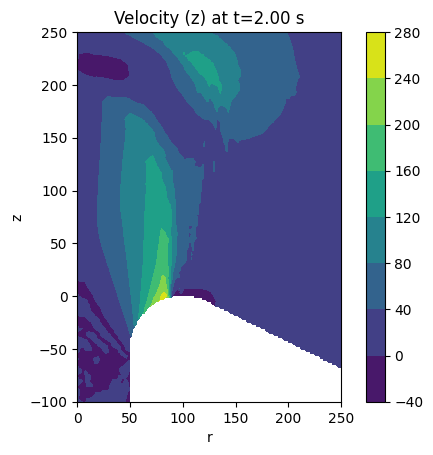

In [716]:
t_ind=30
plt.contourf(mg_x, mg_y, mg_u[t_ind,:,:])
plt.xlim(0, 250)
plt.ylim(-100, 250)
plt.gca().set_aspect('equal')  # Set equal aspect ratio
plt.colorbar()
plt.title(f"Velocity (z) at t={t_range[file_index_list[t_ind]]:.2f} s")
plt.xlabel("r")
plt.ylabel("z")


## Green's function analytical derivative

Considering this Green's function

$$
G(\bar{x}, \bar{x}', t) = \frac{\delta(t - \frac{|\bar{x} - \bar{x}'|}{c_0})}{4 \pi (\bar{x} - \bar{x}')}
$$

the temporal derivatives become

$$
\frac{\partial G}{\partial t} = \frac{\delta'(t - \frac{|\bar{x} - \bar{x}'|}{c_0})}{4 \pi |\bar{x} - \bar{x}'|}
$$

and the spatial derivative becomes

$$
\frac{\partial G}{\partial \bar{x}_i'} = \frac{\delta'(t - \frac{|\bar{x} - \bar{x}'|}{c_0}) (\bar{x}_i - \bar{x}'_i)}{4 \pi c_0 |\bar{x} - \bar{x}'|^2} - \frac{\delta(t - \frac{|\bar{x} - \bar{x}'|}{c_0}) (\bar{x}_i - \bar{x}_i')}{4 \pi |\bar{x} - \bar{x}'|^3}
$$


## Logic for numerical solution 

### Monopole term 

$$
\int n_i (\rho v_i) \frac{\partial G}{\partial t} dS \equiv \sum_k \frac{1}{4\pi r_k} \frac{\partial}{\partial \tau} [(\rho(v \cdot n_k))]_{\tau_k} dS_k
$$

The retarded time derivative can be calculated by finite differences. 

### Dipole term 

$$
-\int n_i (\rho v_i v_j + P_{ij}) \frac{\partial G}{\partial x_i}dS \equiv - \frac{1}{4 \pi} \nabla_x \cdot \int_S \frac{F(x')}{r} dS(x')
$$

where 

$$
\vec{F} = \vec{n} \cdot (\rho \vec{v}\vec{v} + P)
$$

For the dipole term, we break the divergence into a finite difference approximation.

$$
\nabla \cdot U \equiv \sum_{i=1}^d \frac{U_i(x + \Delta x \vec{e}_i) - U_i(x - \Delta x \vec{e}_i)}{2 \Delta x}
$$

In [864]:
import numpy as np
import scipy.interpolate as interp
from scipy.interpolate import RegularGridInterpolator


def xyz_to_rz(vec):
    """ Convert a 3-vector to cylindrical coordinates (r, z)."""
    r = np.sqrt(vec[0]**2 + vec[1]**2)
    z = vec[2]
    return np.array([r, z])


def rz_to_xyz(vec, normal):
    """Convert a 2-vector to cartesian coordinates. (x, y, z)
    """

    r = vec[0]
    z = vec[1]

    if r>0:
        xy_unit = normal[:2]/np.linalg.norm(normal[:2])
    else:
        xy_unit = np.zeros(2)

    return np.array([r * xy_unit[0], r * xy_unit[1], z])

def compute_pressure_prime(x_obs, t, x_prime, dS, n, c0, times, rho_data, v_data, sigma_data, points, dt=0.05, dx=0.1):
    """
    x_obs - Observation point (2D array of shape (2,))
    t - Time at which to compute the pressure
    x_prime - Source points (2D array of shape (N, 2))
    dS - Surface element area at each source point (1D array of shape (N,))
    n - Normal vector at each source point (2D array of shape (N, 2))
    c0 - Speed of sound
    times - Time array for interpolation
    rho_data - Density data as an interpolator [3600, 200, 200]
    v_data - Velocity data as an interpolator [3600, 200, 200, 2]
    sigma_data - Stress tensor data as an interpolator [3600, 200, 200, 2, 2]
    points - Points for interpolation grid
    dt - Time step for interpolation (default: 0.01)
    dx - Spatial step for interpolation (default: 0.01)m.
    """

    N = len(x_prime)

    M_mon_dt_vec = np.zeros(N)
    D_div_vec = np.zeros(N)

    debug_v = []
    debug_rho = []

    # create interpolators for density, velocity, and stress tensor
    rho_interpolator = RegularGridInterpolator(points, rho_data, method='linear', bounds_error=False, fill_value=0)
    v_interpolator = RegularGridInterpolator(points, v_data, method='linear', bounds_error=False, fill_value=0)
    sigma_interpolator = RegularGridInterpolator(points, sigma_data, method='linear', bounds_error=False, fill_value=0)

    for k in range(N):
        # Compute the distance from the source to the observation point
        r = np.linalg.norm(x_obs - x_prime[k])

        x_prime_rz = xyz_to_rz(x_prime[k])
        n_rz = xyz_to_rz(n[k])
        
        # Compute the time of arrival at the observation point
        t_ret = t - r / c0
        
        if t_ret < 0 or t_ret + dt > times[-1]:
            continue
        
        # Interpolate the density and velocity at t=t_ret and x_prime[k]
        rho = np.nan_to_num(rho_interpolator([t_ret, x_prime_rz[0], x_prime_rz[1]]))
        v = np.nan_to_num(v_interpolator([t_ret, x_prime_rz[0], x_prime_rz[1]]))

        debug_v.append(v)
        debug_rho.append(rho)

        # Interpolate the density and velocity at t=t_ret + dt and x_prime[k]
        rho_plus = np.nan_to_num(rho_interpolator([t_ret + dt, x_prime_rz[0], x_prime_rz[1]]))
        v_plus = np.nan_to_num(v_interpolator([t_ret + dt, x_prime_rz[0], x_prime_rz[1]]))

        # Calculate the time derivative of the monopole moment.
        # Do calculations in spherical coordinates
        rho_v_n = rho * np.dot(v, n_rz)
        rho_v_n_plus = rho_plus * np.dot(v_plus, n_rz)

        # Calculate the monopole moment time derivative
        M_mon_dt_vec[k] = (rho_v_n_plus - rho_v_n) / dt / (4 * r * np.pi) * dS[k]


        # Calculate the divergence of the dipole term.
        for i in range(3):  # Loop over x and y dimensions for 2D divergence
            x_plus = x_prime[k].copy()
            x_plus[i] += dx
            x_plus_rz = xyz_to_rz(x_plus)

            r_plus = np.linalg.norm(x_obs - x_plus)
            t_ret_plus = t - r_plus / c0

            x_minus = x_prime[k].copy()
            x_minus[i] -= dx
            x_minus_rz = xyz_to_rz(x_minus)

            r_minus = np.linalg.norm(x_obs - x_minus)
            t_ret_minus = t - r_minus / c0

            # Interpolate in polar coordinates.
            rho = np.nan_to_num(rho_interpolator([t_ret_plus, x_plus_rz[0], x_plus_rz[1]]))
            sigma = np.nan_to_num(sigma_interpolator([t_ret_plus, x_plus_rz[0], x_plus_rz[1]]))
            v_rz = np.nan_to_num(v_interpolator([t_ret_plus, x_plus_rz[0], x_plus_rz[1]]))

            # Convert velocity from cylindrical -> cartesian
            v = rz_to_xyz(v_rz.flatten(), n[k])

            # Compute force term: n[k] · (ρ v v + σ) / (r_plus)
            force_plus = np.sum(n[k] * (rho * np.outer(v, v) + sigma), axis=1) / r_plus

            rho = np.nan_to_num(rho_interpolator([t_ret_minus, x_minus_rz[0], x_minus_rz[1]]))
            sigma = np.nan_to_num(sigma_interpolator([t_ret_minus, x_minus_rz[0], x_minus_rz[1]]))
            v_rz = np.nan_to_num(v_interpolator([t_ret_minus, x_minus_rz[0], x_minus_rz[1]]))
            
            # Convert velocity from cylindrical -> cartesian
            v = rz_to_xyz(v_rz.flatten(), n[k])

            # Compute force term: n[k] · (ρ v v + σ) / (r_minus)
            force_minus = np.sum(n[k] * (rho * np.outer(v, v) + sigma), axis=1) / r_minus

            # Accumulate divergence for component i
            D_div_vec[k] += (force_plus[0,i] - force_minus[0,i]) / (2 * dx) / (4 * np.pi) * dS[k]


    return np.sum(M_mon_dt_vec), np.sum(D_div_vec), np.asarray(debug_v), np.asarray(debug_rho), M_mon_dt_vec, D_div_vec

In [ ]:
N = 20 # number of points for integration
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(-np.pi/6, np.pi/2, N, endpoint=False)

Theta, Phi = np.meshgrid(theta, phi, indexing='ij')

dphi = phi[1] - phi[0]
dtheta = theta[1] - theta[0]
a = 100 # radius of integration [m]

c0 = 320 # speed of sound [m/s]

dS = np.array(a**2 * np.sin(Theta) * dphi * dtheta).flatten()  # differential area element on the sphere

normals = np.array([np.sin(Theta.flatten()) * np.cos(Phi.flatten()), np.sin(Theta.flatten()) * np.sin(Phi.flatten()), np.cos(Theta.flatten())]).T
x_prime = np.array([np.cos(Phi.flatten()) * np.sin(Theta.flatten()) * a, np.sin(Phi.flatten()) * np.sin(Theta.flatten()) * a, np.cos(Theta.flatten()) * a]).T

x_obs = np.array([200, 0, 0])
points_ = (t_range[file_index_list], mg_x[0,:], mg_y[:,0])

print(len(mg_y[:,0]))

200


In [982]:
M_mom_dt = np.zeros((len(t_range[file_index_list])))
D_div = np.zeros((len(t_range[file_index_list])))
p_t = np.zeros((len(t_range[file_index_list])))

M_mom_dt_array = np.zeros((len(t_range[file_index_list]), N**2))
D_div_array = np.zeros((len(t_range[file_index_list]), N**2))

v_debugs = []
debug_rhos = []

for i, t in enumerate(t_range[file_index_list]):
    M_mom_dt[i], D_div[i], v_debug, debug_rho, M_mom_dt_array[i], D_div_array[i] = compute_pressure_prime(x_obs, t, x_prime, dS, normals, c0, t_range[file_index_list], mg_rho, v_data=v_data, sigma_data=mg_sigma, points=points_)

    v_debugs.append(v_debug)
    debug_rhos.append(debug_rho)

    if i % 20 == 0:
        print(f"Computing pressure at time {t} s")


Computing pressure at time 0.0 s


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_99770/1524074551.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M_mon_dt_vec[k] = (rho_v_n_plus - rho_v_n) / dt / (4 * r * np.pi) * dS[k]


Computing pressure at time 1.3333333333244832 s
Computing pressure at time 2.6666666666489665 s
Computing pressure at time 3.9999999999734497 s
Computing pressure at time 5.333333333297933 s
Computing pressure at time 6.666666666622416 s
Computing pressure at time 7.999999999946899 s
Computing pressure at time 9.333333333271382 s
Computing pressure at time 10.666666666595866 s
Computing pressure at time 11.999999999920348 s
Computing pressure at time 13.333333333244832 s
Computing pressure at time 14.666666666569315 s


## Notes on the output

In the below graph we can see that it is the dipole term that appears to dominate. My best guess here is that the dipole term is largely a function of velocity, and the velocity increases even further away from the outlet. In comparison both pressure and density only increase _right in_ the outlet. 

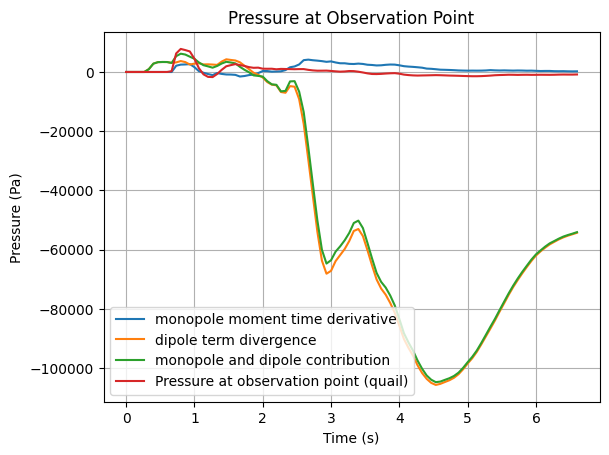

In [983]:
x_idx = np.argmin(np.abs(int_x[0] - 200))
y_idx = np.argmin(np.abs(int_y[:,0] - 0))

delta_p_quail = mg_p[:, y_idx, x_idx] - mg_p[0,y_idx, x_idx]

plt.plot(t_range[file_index_list[0:100]], M_mom_dt[0:100], label='monopole moment time derivative')
plt.plot(t_range[file_index_list[0:100]], -D_div[0:100], label="dipole term divergence")
plt.plot(t_range[file_index_list[0:100]], M_mom_dt[0:100] - D_div[0:100], label="monopole and dipole contribution ")

plt.plot(t_range[file_index_list[0:100]], delta_p_quail[0:100], label="Pressure at observation point (quail)")
plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid()
plt.show()

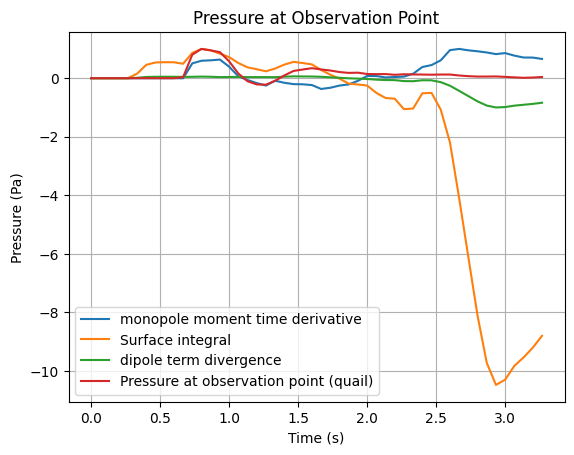

In [984]:
x_idx = np.argmin(np.abs(int_x[0] - 200))
y_idx = np.argmin(np.abs(int_y[:,0] - 0))

delta_p_quail = mg_p[:, y_idx, x_idx] - mg_p[0,y_idx, x_idx]

plt.plot(t_range[file_index_list[0:50]], M_mom_dt[0:50]/np.max(np.abs( M_mom_dt[0:50])), label='monopole moment time derivative')
plt.plot(t_range[file_index_list[0:50]], (M_mom_dt - D_div)[0:50]/np.max((M_mom_dt - D_div)), label='Surface integral')
plt.plot(t_range[file_index_list[0:50]], -D_div[0:50]/np.max(np.abs(D_div[0:50])), label="dipole term divergence")

plt.plot(t_range[file_index_list[0:50]], delta_p_quail[0:50]/np.max(np.abs(delta_p_quail[0:50])), label="Pressure at observation point (quail)")
plt.legend()

plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid()
plt.show()

### Normalized plots

## interpolated velocity

WHHHHYYY is this interpolating values that are not zero as zero?????

This demonstrates the weird shit that I don't understand. 

Whhyy am I getting Nann returned when the plot clearly shows the value is not Nan???? That makes no sense. 

In [1106]:
v_data.shape

(225, 200, 200, 2)

at point x = 48.24120603015076 which is also 48.24120603015076 and y = 84.29648241206027 which is also 84.29648241206027 we interpolated v as [nan nan]
i: 32 and j: 98
at point x = 49.74874371859297 which is also 49.74874371859297 and y = 84.29648241206027 which is also 84.29648241206027 we interpolated v as [nan nan]
i: 33 and j: 98
at point x = 51.25628140703518 which is also 51.25628140703518 and y = 84.29648241206027 which is also 84.29648241206027 we interpolated v as [nan nan]
i: 34 and j: 98


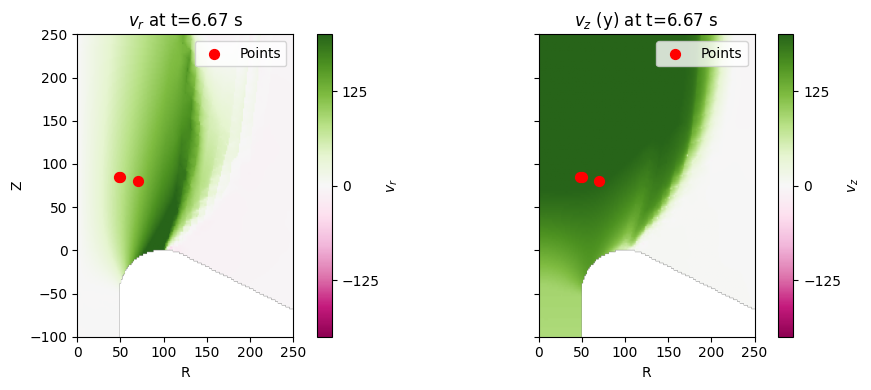

In [1109]:
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=-200, vcenter=0, vmax=200)

v_interpolator = RegularGridInterpolator(points_, v_data, method='linear', bounds_error=False, fill_value=0)

v_i = np.zeros((200,200,2))
idx = 100

number_of_nans = 0

R = np.linspace(0, 300, 200)
Z = np.linspace(-125, 300, 200)
for i in range(200):
    for j in range(200):
        v_i[i, j] = v_interpolator([t_range[file_index_list[idx]], R[i], Z[j]])

        if np.any(np.isnan(v_i[i, j])):
            number_of_nans += 1

        if R[i] < 52 and R[i] > 48:
            if Z[j] < 86 and Z[j] > 84:
                print(f"at point x = {mg_x[0,i]} which is also {R[i]} and y = {mg_y[j,0]} which is also {Z[j]} we interpolated v as {v_i[i,j]}")
                print(f"i: {i} and j: {j}")

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# First subplot: Dipole (z) component (v_i[:,:,0])
cf1 = ax1.imshow(v_i[:,:,0], cmap='PiYG', extent=[R.min(), R.max(), Z.max(), Z.min()], norm=norm)
cbar1 = fig.colorbar(cf1, ax=ax1, aspect=20, ticks=[-250, -125, 0, 125, 250], label='$v_r$')
cbar1.ax.tick_params(labelsize=10)
ax1.scatter([50, mg_x[0, 32], 70], [85, mg_y[98, 0], 80], c='red', s=50, marker='o', label='Points')
ax1.set_xlim(0, 250)
ax1.set_ylim(-100, 250)
ax1.set_aspect('equal')
ax1.set_xlabel('R')
ax1.set_ylabel('Z')
ax1.set_title(f"$v_r$ at t={t_range[file_index_list[idx]]:.2f} s")
ax1.legend()

# Second subplot: Dipole (y) component (v_i[:,:,1])
cf2 = ax2.imshow(v_i[:,:,1], cmap='PiYG', extent=[R.min(), R.max(), Z.max(), Z.min()], norm=norm)
cbar2 = fig.colorbar(cf2, ax=ax2, aspect=20, ticks=[-250, -125, 0, 125, 250], label='$v_z$')
cbar2.ax.tick_params(labelsize=10)
ax2.scatter([50, mg_x[0, 32], 70], [85, mg_y[98, 0], 80], c='red', s=50, marker='o', label='Points')
ax2.set_xlim(0, 250)
ax2.set_ylim(-100, 250)
ax2.set_aspect('equal')
ax2.set_xlabel('R')
ax2.set_title(f"$v_z$ (y) at t={t_range[file_index_list[idx]]:.2f} s")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [1116]:
v_interpolator([t_range[file_index_list[100]], 50, 90])

print(np.sum(np.isnan(v_i[:,:,1])))

print(number_of_nans)

6921
6921


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_99770/3529283321.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_99770/3529283321.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


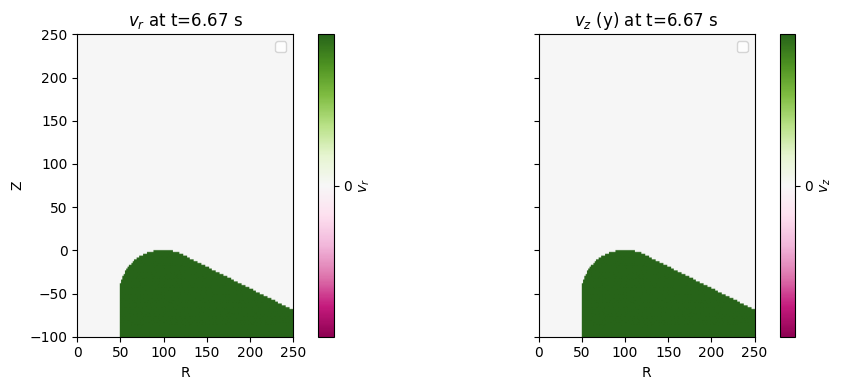

In [1117]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# First subplot: Dipole (z) component (v_i[:,:,0])
cf1 = ax1.imshow(np.isnan(v_i[:,:,0]), cmap='PiYG', extent=[R.min(), R.max(), Z.max(), Z.min()], norm=norm)
cbar1 = fig.colorbar(cf1, ax=ax1, aspect=20, ticks=[-250, -125, 0, 125, 250], label='$v_r$')
cbar1.ax.tick_params(labelsize=10)
#ax1.scatter([50, mg_x[0, 32], 70], [85, mg_y[98, 0], 80], c='red', s=50, marker='o', label='Points')
ax1.set_xlim(0, 250)
ax1.set_ylim(-100, 250)
ax1.set_aspect('equal')
ax1.set_xlabel('R')
ax1.set_ylabel('Z')
ax1.set_title(f"$v_r$ at t={t_range[file_index_list[idx]]:.2f} s")
ax1.legend()

# Second subplot: Dipole (y) component (v_i[:,:,1])
cf2 = ax2.imshow(np.isnan(v_i[:,:,1]), cmap='PiYG', extent=[R.min(), R.max(), Z.max(), Z.min()], norm=norm)
cbar2 = fig.colorbar(cf2, ax=ax2, aspect=20, ticks=[-250, -125, 0, 125, 250], label='$v_z$')
cbar2.ax.tick_params(labelsize=10)
#ax2.scatter([50, mg_x[0, 32], 70], [85, mg_y[98, 0], 80], c='red', s=50, marker='o', label='Points')
ax2.set_xlim(0, 250)
ax2.set_ylim(-100, 250)
ax2.set_aspect('equal')
ax2.set_xlabel('R')
ax2.set_title(f"$v_z$ (y) at t={t_range[file_index_list[idx]]:.2f} s")
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 2D plots of interpolated z values

[-125.              -122.8643216080402 -120.7286432160804
 -118.5929648241206 -116.4572864321608]


Text(0.5, 1.0, 'cross section at R=100')

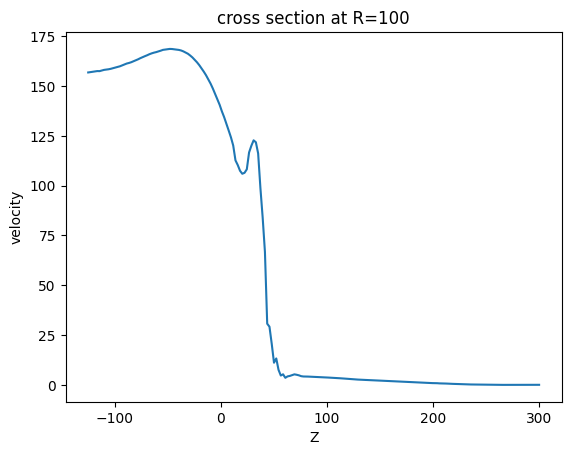

In [ ]:
velocity_10 = np.zeros((200,2))
velocity_50 = np.zeros((200,2))
velocity_100 = np.zeros((200,2))
velocity_150 = np.zeros((200,2))

print(Z[0:5])

for i in range(200):
    velocity_100[i] = v_interpolator([t_range[file_index_list[idx]], 100, Z[i]])
    velocity_10[i] = v_interpolator([t_range[file_index_list[idx]], 10, Z[i]])
    velocity_50[i] = v_interpolator([t_range[file_index_list[idx]], 50, Z[i]])
    velocity_150[i] = v_interpolator([t_range[file_index_list[idx]], 150, Z[i]])


plt.plot(Z, velocity_10[:,1], label="R=10")
plt.plot(Z, velocity_50[:,1], label="R=50")
plt.plot(Z, velocity_10[:,1], label="R=10")
plt.plot(Z, velocity_10[:,1], label="R=10")
plt.xlabel("Z")
plt.ylabel("velocity")
plt.title("cross section at R=100")

Text(0.5, 1.0, 'cross section at Z=100')

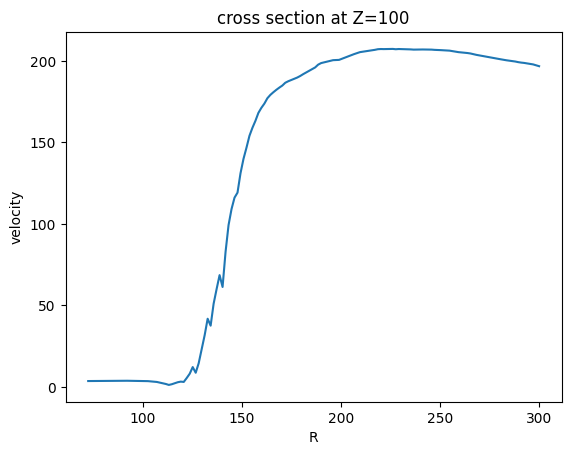

In [1088]:
line_of_velocity = np.zeros((200,2))

for i in range(200):
    line_of_velocity[i] = v_interpolator([t_range[file_index_list[100]], R[i], 100])


plt.plot(R, line_of_velocity[:,1])
plt.xlabel("R")
plt.ylabel("velocity")
plt.title("cross section at Z=100")

array([[ 82.8033536688689 , 168.53365209236313]])

x_prime shape: (400, 3)


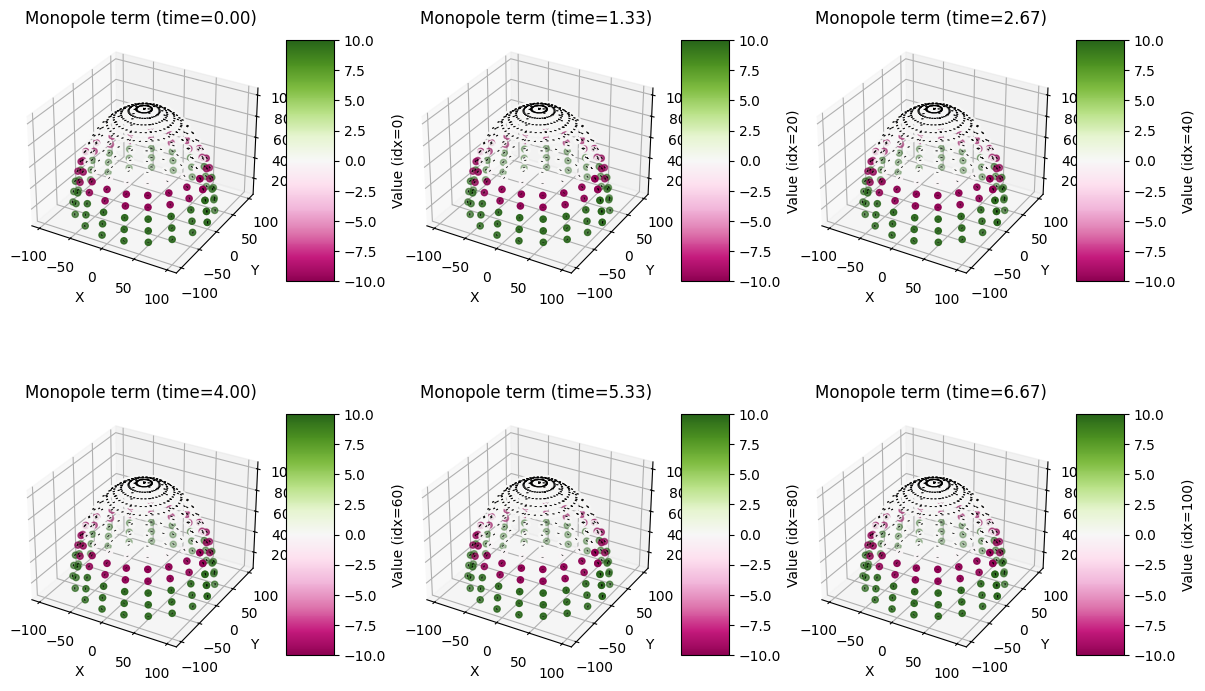

In [986]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Define the indices for the six plots
idx_values = [0, 20, 40, 60, 80, 100]  # Modify as needed

# Create a 3x2 grid of subplots with 3D projection
fig, axes = plt.subplots(2, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})

# Flatten axes for easier iteration (axes is a 3x2 array)
axes = axes.flatten()

# Debug: Check x_prime shape
print("x_prime shape:", x_prime.shape)

# Loop over idx values and create each scatter plot
for i, idx in enumerate(idx_values):
    # Set symmetric normalization around zero
    vmax = np.abs(M_mom_dt_array[idx]).max()
    norm = TwoSlopeNorm(vmax=10, vcenter=0, vmin=-10)

    # Create scatter plot on the current subplot
    sc = axes[i].scatter(x_prime[:, 0], x_prime[:, 1], x_prime[:, 2], 
                         c=v_debug[:,0,0], cmap='PiYG', norm=norm)

    # Quiver plot for normal vectors
    scale_factor = 1
    axes[i].quiver(x_prime[:, 0], x_prime[:, 1], x_prime[:, 2],
                   normals[:, 0], normals[:, 1], normals[:, 2],
                   color='black', length=scale_factor, normalize=True, arrow_length_ratio=0.3)
    
    # Add colorbar for the current subplot
    plt.colorbar(sc, ax=axes[i], shrink=1, aspect=5, label=f'Value (idx={idx})')

    # Customize axes
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
    axes[i].set_zlabel('Z')
    axes[i].set_title(f'Monopole term (time={t_range[file_index_list[idx]]:.2f})')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

x_prime shape: (900, 3)


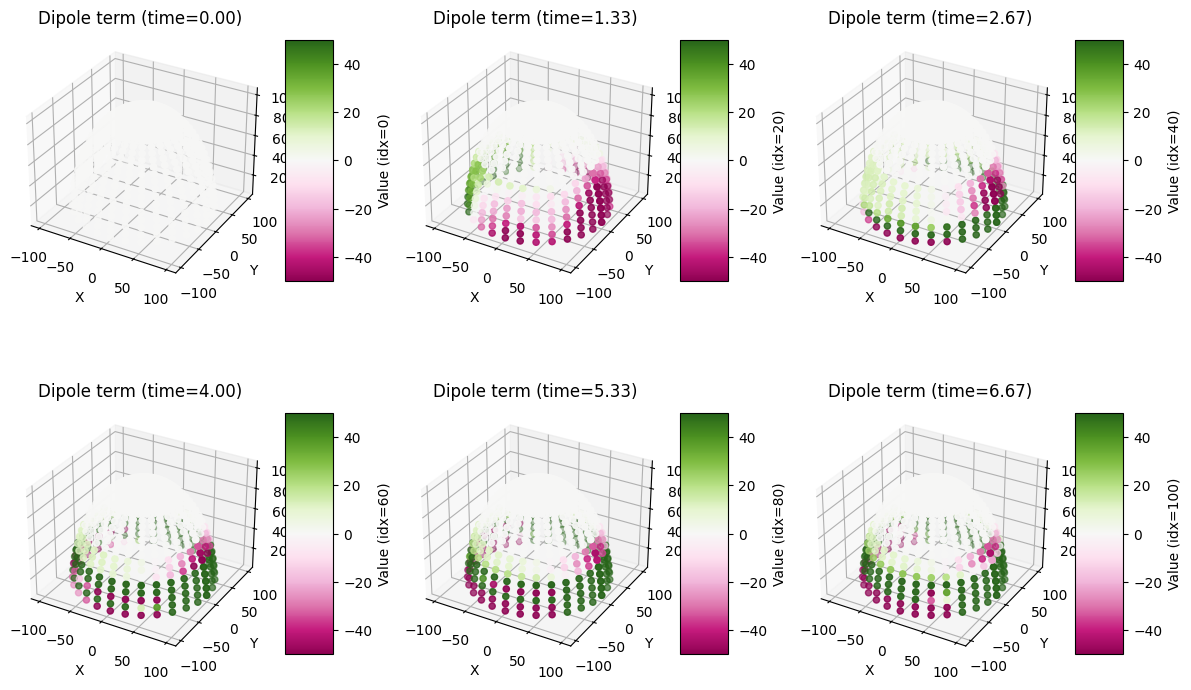

In [843]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm


# Create a 3x2 grid of subplots with 3D projection
fig, axes = plt.subplots(2, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})

# Flatten axes for easier iteration (axes is a 3x2 array)
axes = axes.flatten()

# Debug: Check x_prime shape
print("x_prime shape:", x_prime.shape)

# Loop over idx values and create each scatter plot
for i, idx in enumerate(idx_values):
    # Set symmetric normalization around zero
    vmax = np.abs(D_div_array[idx]).max()
    norm = TwoSlopeNorm(vmax=50,vcenter=0, vmin=-50)

    # Create scatter plot on the current subplot
    sc = axes[i].scatter(x_prime[:, 0], x_prime[:, 1], x_prime[:, 2], 
                         c=D_div_array[idx], cmap='PiYG', norm=norm)
    
    # Add colorbar for the current subplot
    plt.colorbar(sc, ax=axes[i], shrink=1, aspect=5, label=f'Value (idx={idx})')

    # Customize axes
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
    axes[i].set_zlabel('Z')
    axes[i].set_title(f'Dipole term (time={t_range[file_index_list[idx]]:.2f})')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()